In [31]:
%reset -f
%reset -f


In [32]:
#Parametros de entrada
wd=1;#ancho de la ventana de prediccion
inp=0.285;#factor de modulacion
indim=1/inp; #inverso del factor de modulacion
fcent=0.33; #frecuencia de portadora 0.33
feature1,feature2 = 90,90; #parametro para prediccion, cada 'feature' datos predice 'wd' salidas
nrep=1              #numero de repeticiones por cada feature, para obtener promedios de variables

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from numpy.random import randn
from numpy.random import seed
from scipy import stats
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

In [34]:
#Lectura de datos de potencia de senial
pd.set_option('display.float_format', lambda x: '%.4f' % x)
#df=pd.read_csv('LTSMSpectrum_FIR.txt', delimiter=';')
#df=pd.read_csv('FIR2.csv', delimiter=',')
df=pd.read_csv('DATA.csv', delimiter=',')



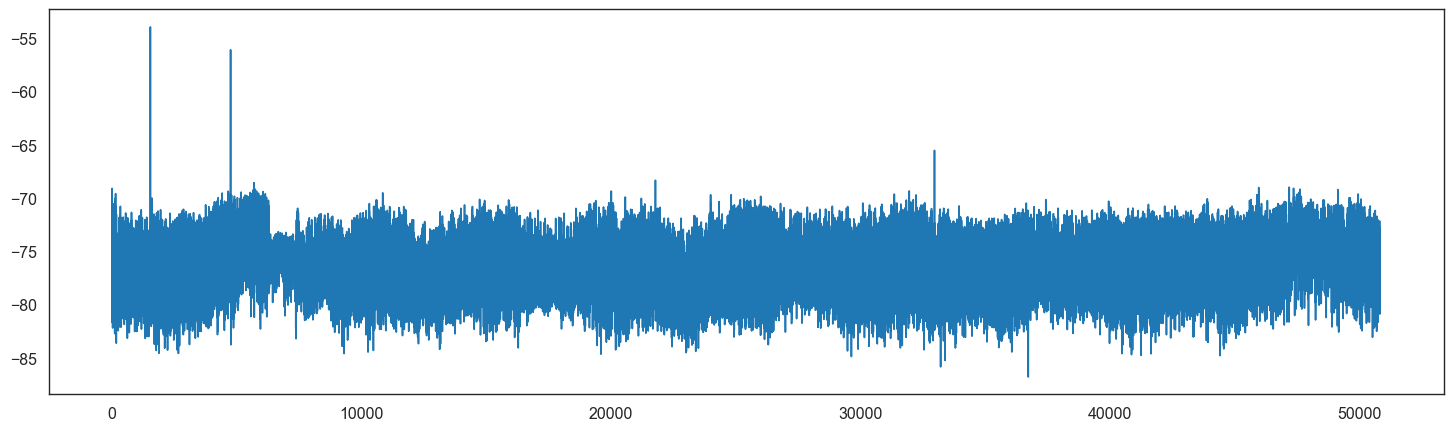

Number of rows and columns: (50824, 5)
       CH1      CH2      CH3      CH4      CH5
0 -76.8590 -72.9390 -71.6840 -40.7870 -84.3490
1 -76.7910 -67.8820 -75.0240 -43.1180 -84.8000
2 -74.2920 -66.1490 -72.3020 -45.0650 -85.2520
3 -73.9040 -67.3230 -72.1070 -44.1170 -86.1640
4 -76.1990 -71.0840 -73.5380 -46.7500 -84.8150


50824

In [35]:
#Se escoje canal para predicccion
rssi1=df.CH1.values
#se grafican datos de entrada
plt.figure(figsize=(18,5))
plt.plot(rssi1[:])
plt.show()
print('Number of rows and columns:', df.shape)
print (df.head(5))
len(df)

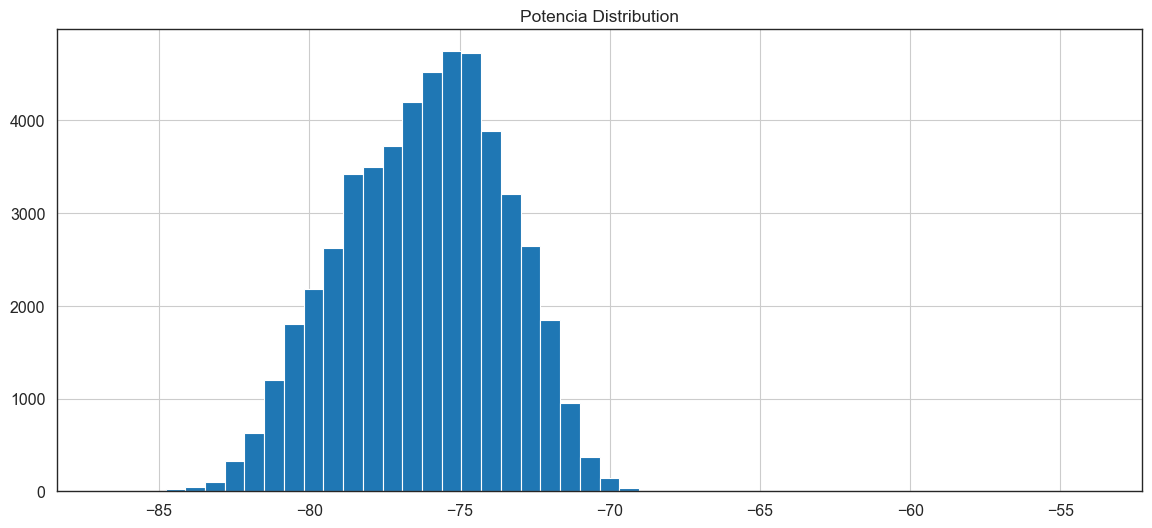

In [36]:
#eSTADISTICA para Limitar datos aberrantes. 
CANAL='CH1'
plt.figure(figsize=(14,6))
df[CANAL].hist(bins=50)
plt.title('Potencia Distribution');


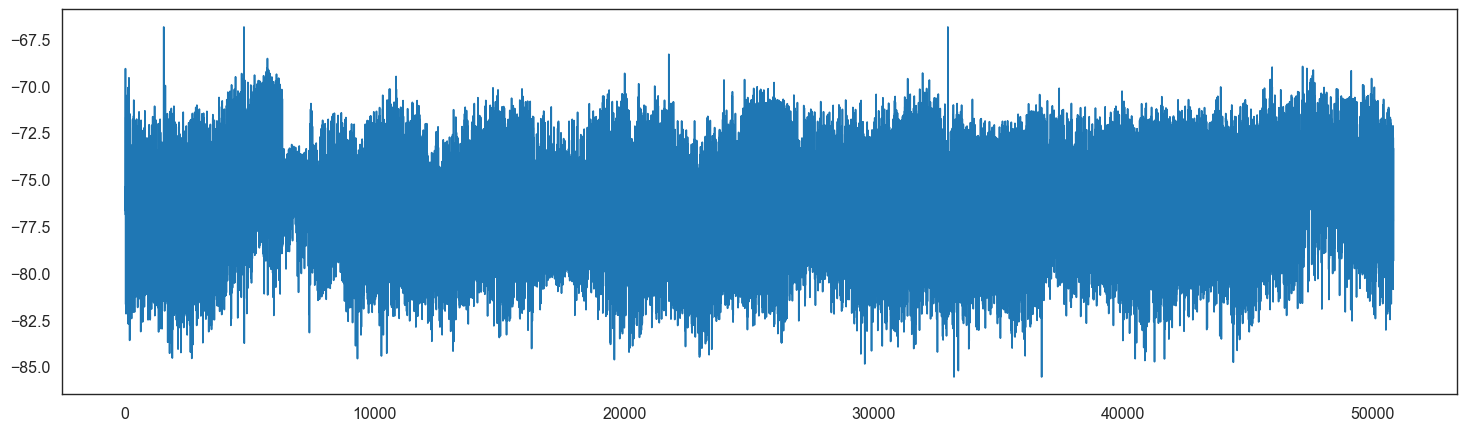

In [37]:
#Se limitan valores a media+-3.5*varianza
media_data=np.mean(rssi1, axis = None);
#print(media_data);
std_data=np.std(rssi1, axis = None);
#print(std_data)
max_data=media_data+3.5*std_data; #OJO se cambiO a 2.5
min_data=media_data-3.5*std_data; # OJO se cambio a -2.5
#rssi1=rssi
for i in range (len(rssi1)):
    if rssi1[i]>max_data:
        rssi1[i]=max_data
    if rssi1[i]<min_data:
        rssi1[i]=min_data
    
plt.figure(figsize=(18,5))
plt.plot(rssi1[:])
plt.show()

    

In [38]:
print(media_data, std_data)

-76.19114656461514 2.670543399605108


In [39]:
df=pd.read_csv('DATA.csv', delimiter=',')
rssi=df.CH1.values
from sklearn.metrics import mean_squared_error
mean_squared_error(rssi,rssi1)

0.005632956844131837

In [40]:
#dividiendo la data para entrenamiento, pruebas y predicciones
spec_size1= int(len(rssi1) * 0.20)# 0.20 tamanio datos para predicción
dataset_model =len(rssi1)-spec_size1 #tamanio datos para entrenamiento y prueba
print(dataset_model, spec_size1)

40660 10164


In [41]:
#limitando el archivo de modulacion al 80% de datos
mdt=rssi1[spec_size1:]; #mdt=rssi1[spec_size1:]
mdt = np.reshape(mdt, (-1, 1));#formando el arreglo
print(mdt.shape)
print(spec_size1)


(40660, 1)
10164


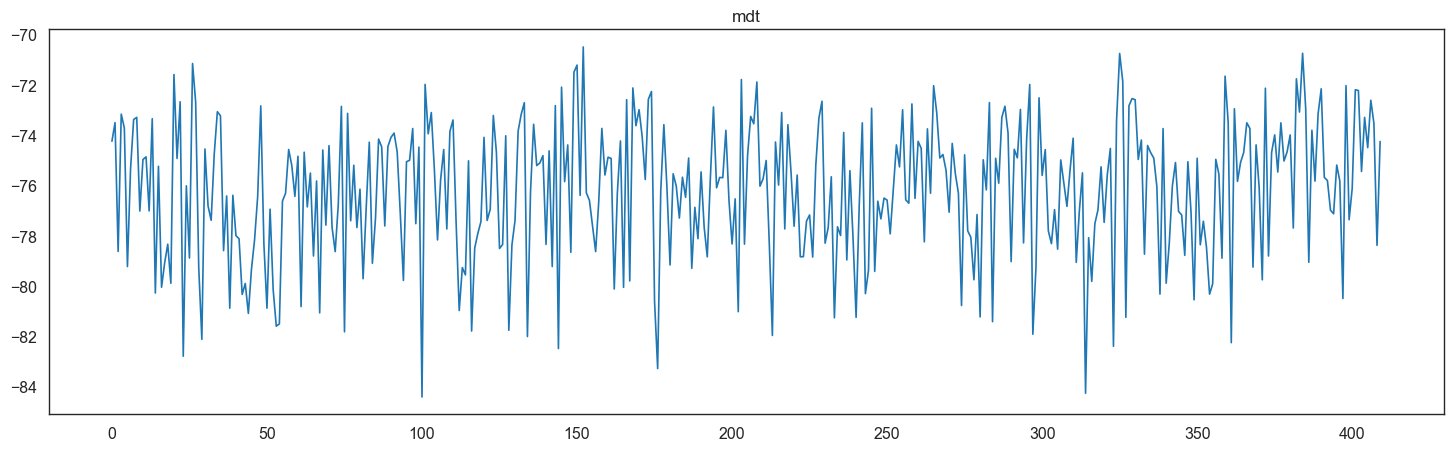

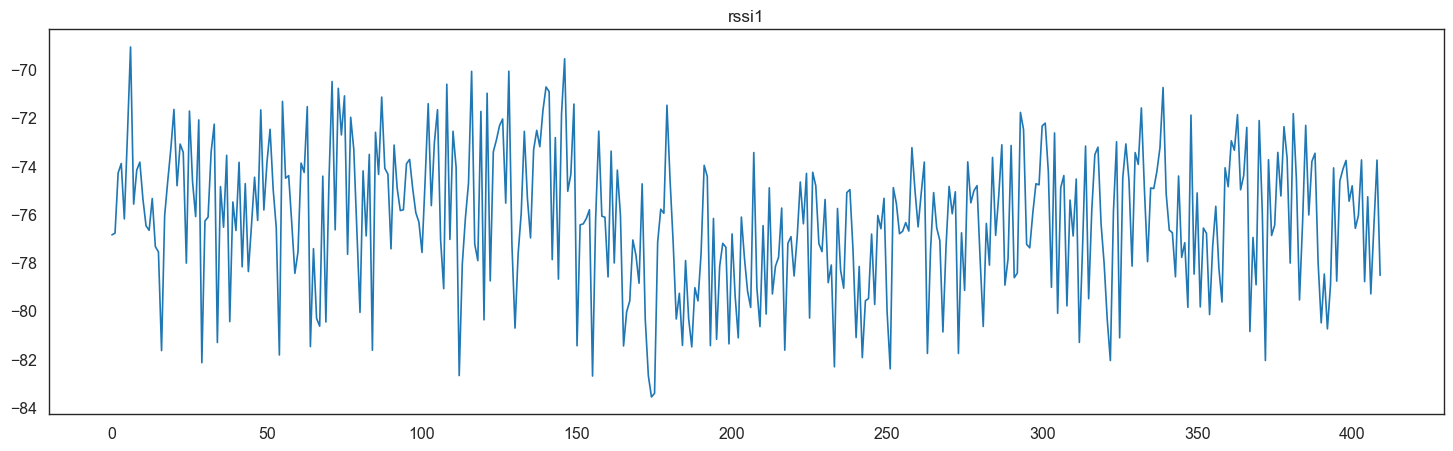

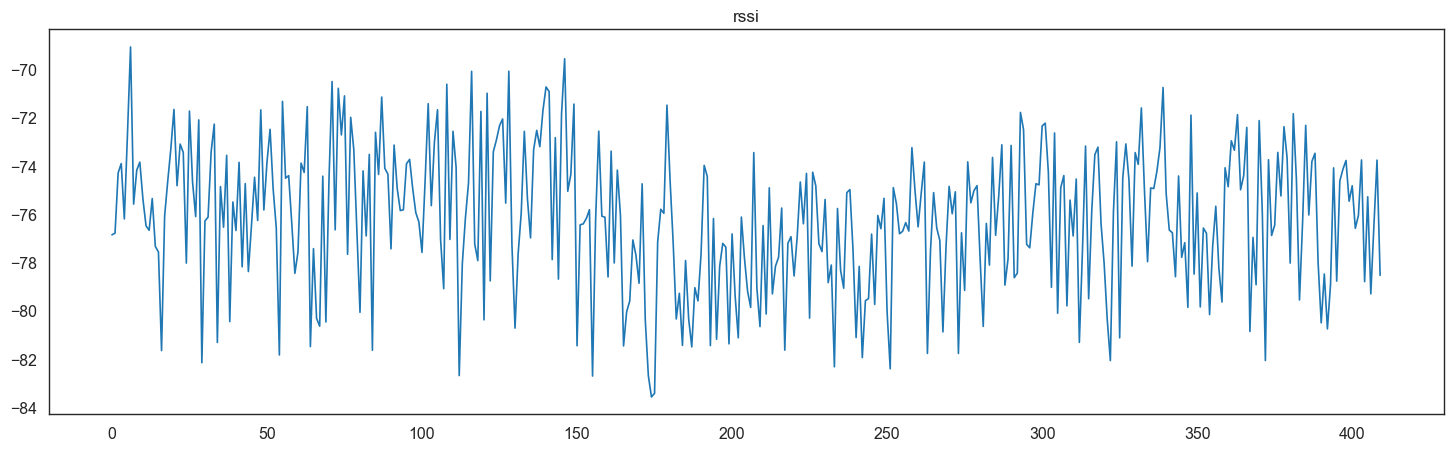

In [42]:
plt.figure(figsize=(18,5))
plt.plot(mdt[:410])
plt.title('mdt')
plt.show()

plt.figure(figsize=(18,5))
plt.plot(rssi1[:410])
plt.title('rssi1')
plt.show()

plt.figure(figsize=(18,5))
plt.plot(rssi[:410])
plt.title('rssi')
plt.show()

In [43]:
# definiendo el tiempo

t=np.arange(0,len(rssi1)*8,7.2);#realizando intervalos de 7.2 seg
t1=np.arange(0,len(t)*8,0.01);#realizando intervalos de 0.01 seg

print('#t:',len(t),'#t1:',len(t1))

#t: 56472 #t1: 45177600


In [44]:
ifea_max=int(feature2/feature1)
nfil=int(nrep*feature2/feature1)
mfil=5
resultados=[]
for i in range(nfil):
    a=[0]*mfil
    resultados.append(a)


In [45]:
#argum_m=[]
#argum_m=[None]*(dataset_model)

#for i in range(dataset_model):
#    argum_m[i]=np.pi*2*fcent*t[i+spec_size1];#muestreo de fase por cada muestra de senial modulante


###### Modulacion de datos

In [46]:
## modulando
import math
from decimal import *
#senial modulada=cos(angulo); angulo=argum+fidt
fidt=[];
fidt=[None]*len(mdt)
fidt=np.asarray(fidt)
for i in range(len(mdt)):
    fidt[i]=inp*mdt[i];#fase modulante

argum=[]
argum=[None]*(len(t1)-spec_size1*800)
argum=np.asarray(argum)
for i in range(len(argum)):
    argum[i]=np.pi*2*fcent*t1[i+spec_size1*800];#fase de portadora

#argum=argum.reshape(argum,(-1,1));#formando arreglo
argum_m=[]
argum_m=[None]*(dataset_model)
argum_m=np.asarray(argum_m)
for i in range(dataset_model):
    argum_m[i]=np.pi*2*fcent*t[i+spec_size1];#muestreo de fase por cada muestra de senial modulante
#argum_m=argum_m.reshape (argum_m,(-1,1));#formando arreglo

fase=[];#angulo=argum+fidt
fase=[None]*(dataset_model)
fase=np.asarray(fase)
for i in range(len(argum_m)):
    fase[i]=fidt[i]+argum_m[i];
y_2=[]
y_1=[]
for i in range(len(t1)-1-spec_size1*800):
        y_2.append(np.cos(argum[i]))# senial portadora
    
for i in range(dataset_model):#len(t)-spec_size1-1
    y_1.append(np.cos(fase[i]))# senial modulada    

from array import array
import numpy as np
y_1=np.asarray(y_1)
y_2=np.asarray(y_2)

In [47]:
print(len(y_2),len(y_1))
   


37046399 40660


In [48]:
#print(mdtprueba[1],rssi1[3],media_data)

###### Graficando senial modulada

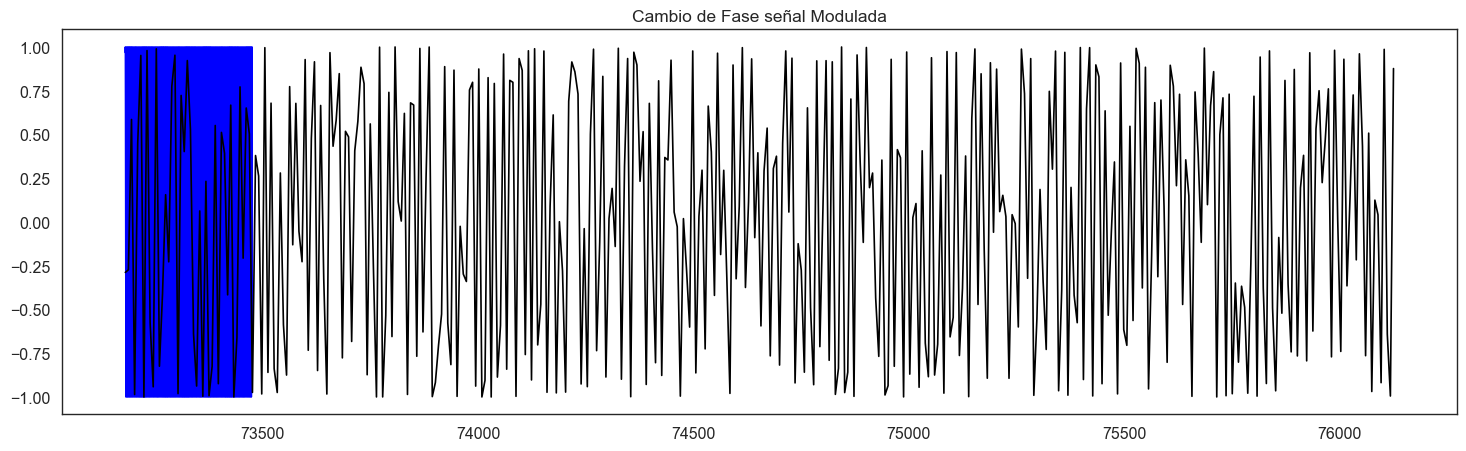

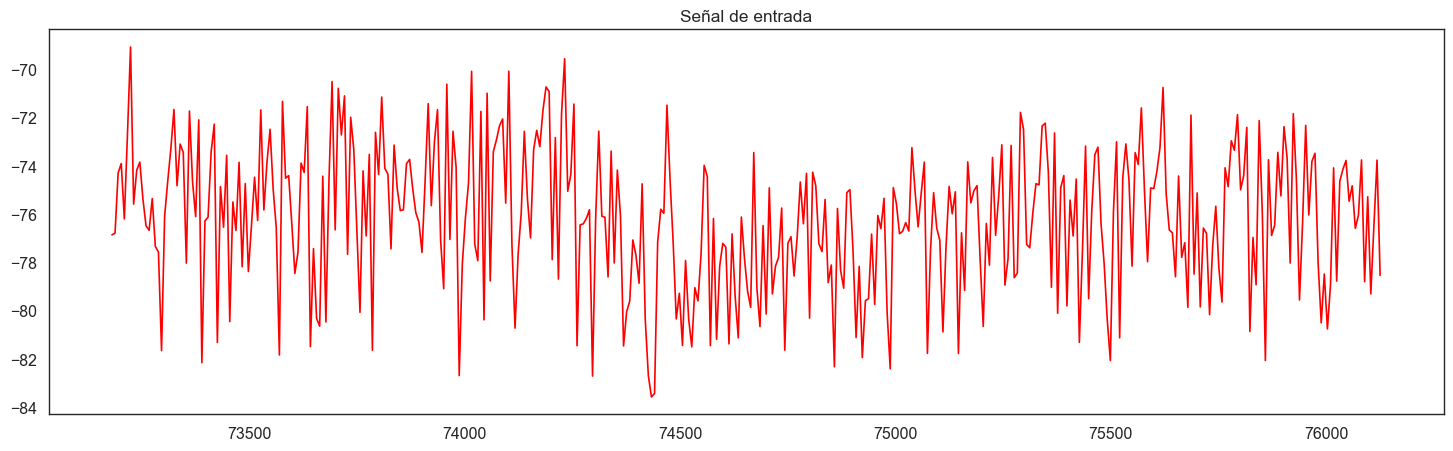

In [49]:
#Portadora y senial "cambio de fase" de senial modulada
plt.figure(figsize=(18,5))
plt.plot(t1[spec_size1*720:spec_size1*720+29520], y_2[:29520], color = 'b')
#plt.stem(t[spec_size1:spec_size1+41], y_1[:41],'k','o',)
plt.plot(t[spec_size1:spec_size1+410], y_1[:410],color='k')
plt.title("Cambio de Fase señal Modulada")
plt.show()

plt.figure(figsize=(18,5))
plt.plot(t[spec_size1:spec_size1+410], rssi1[:410],color='r')
plt.title("Señal de entrada")
plt.show()


In [50]:
#señal modulante vs. cambio de fase
#plt.figure(figsize=(18,5))
#plt.plot(t[spec_size1:spec_size1+400], mdt[:400], color = 'b', marker = "*",)
#plt.stem(t[spec_size1:spec_size1+400], y_1[:400],'k',"o",)
#plt.stem(t[spec_size1:spec_size1+400], mdt[:400],'b', "*",)
#plt.title("Señal Modulante")  
#plt.xlabel("X")  
#plt.ylabel("Y")  
#plt.show()


## LSTM
Procesamiento de datos:
    
    -Se forman los conjuntos de entrenamiento (80%) y testeo (20%)

In [51]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [52]:
#Define tamanio de archivo para entrenamiento y pruebas
#y_1=np.asarray(y_1)
dataset = y_1#valores de los cambios de fase de la señal modulada
dataset = dataset.astype('float32')
dataset = np.reshape(dataset, (-1, 1)) #lo convierte en un vector 1D

scaler = MinMaxScaler(feature_range=(-1, 1)) # funcion para normalizar
dataset = scaler.fit_transform(dataset) # normaliza los datos

train_size = int(dataset_model* 0.80) #toma el 80% de los datos para entrenamiento
test_size = dataset_model - train_size #deja el 20% de datos para pruebas
#spectrum=dataset[0:spec_size,:];#archivo para prediccion
train, test = dataset[:train_size,:], dataset[train_size:train_size+test_size,:] # asigna datos

In [53]:
print(len(test), dataset_model,train_size,test_size,spec_size1)

8132 40660 32528 8132 10164


In [54]:
#Función para crear archivos de entrenamiento y prueba
#ft : features to train
#wd : size of window

def create_dataset(dataset, ft,wd):
    X, Y = [], []
    for i in range(len(dataset)-ft-1):
        a = dataset[i:(i+ft),0]
        X.append(a)
        b = dataset[(i+ft):(i+ft+wd),0]
        Y.append(b)
    return np.array(X), np.array(Y)

#Función para calcular disponibilidad

def disponibility(dataset,th):
    predict=[]
    predict_val=0
    for i in range(len(dataset)):
        if dataset[i]<th:
            predict.append(0);
            predict_val+=1
        else:
            predict.append(1);
    return predict, predict_val




In [55]:
kcont=0
feature=0
for ifea in range(ifea_max):  #features
    feature=feature1*(ifea+1)
    for jfea in range (nrep):   #repeticiones
        X_train, Y_train = create_dataset(train, feature,wd);#entradas y salidas para entrenamiento
        X_test, Y_test = create_dataset(test, feature,wd);#entradas y salidas para pruebas
        X_train= np.array(X_train);#formando arreglo
        X_test=np.array(X_test);#formando arreglo
        X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]));#formando archivo 3D
        X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]));#formando archivo 3D
        
        #Modelo LSTM, prediccion
        b_siz=1024 ###
        model = Sequential()
        model.add(LSTM(500, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='sgd',metrics=['accuracy'])
        epocas_model=20
        history = model.fit(X_train, Y_train, epochs=epocas_model, batch_size=b_siz, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

        model.summary()
        
        train_error=history.history['loss']
        test_error=history.history['val_loss']
        from sklearn.metrics import mean_squared_error
        error_train_test=mean_squared_error(train_error,test_error);
        #print('error cuadratico medio del modelo LSTM :',error_train_test)
        
        #PREPARACION DE DATOS PARA PREDICCION
        spec_size= int(len(rssi1) * 0.20)# tamanio datos para predicción
        spectrum=rssi1[:spec_size];# Define datos para prediccion
        spectrum = np.reshape(spectrum, (-1, 1));#formando el arreglo

        #Modulacion de nuevos datos
        fidt_p=[];
        fidt_p=(inp*spectrum);#fase modulante
        argum_p=[]
        argum_p=np.pi*2*fcent*t1[:spec_size*800];#fase de portadora
        argum_p=argum_p.reshape(-1,1);#formando arreglo
        argum_mp=[]
        argum_mp=np.pi*2*fcent*t[:spec_size];#muestreo de fase por cada muestra de senial modulante
        argum_mp=argum_mp.reshape(-1,1);#formando arreglo

        fase_p=[];#angulo=argum+fidt
        fase_p=fidt_p+argum_mp;
        y_2p=[]
        y_1p=[]
        for i in range(len(spectrum)*800):
            y_2p.append(np.cos(argum_p[i]))# senial portadora
    
        for i in range(len(spectrum)):
            y_1p.append(np.cos(fase_p[i]))# senial modulada    

        from array import array
        import numpy as np
        y_1p=np.asarray(y_1p)
        y_2p=np.asarray(y_2p)
        
        #Calcula correccion de fase
        fase_equiv=[]
        corrige_fase=[]
        for i in range(len (spectrum)):
            fase_equiv.append(np.arccos(y_1p[i]))
            corrige_fase.append(fase_p[i]-fase_equiv[i]) ##############SACAR EL 0.8
        fase_equiv=np.asarray(fase_equiv)
        corrige_fase=np.asarray(corrige_fase)
        y_1p = np.reshape(y_1p, (-1, 1)) #lo convierte en un vector 1D
        
        #Tratamiento de datos para la prediccion
        argum1=[]
        corrigefase=[]
        for i in range(spec_size):
            argum1.append(argum_mp[i])
    
        argum1=np.asarray(argum1)

        X_new1, argum2 = create_dataset(argum1, feature,wd)

        Xnew2,fhase2= create_dataset(fase_p,feature,wd)
        X_phase,corrigefase=create_dataset(corrige_fase,feature,wd)

        argum2=argum2.reshape(-1,1);#formando arreglo
        fhase2=fhase2.reshape(-1,1);#formando arreglo
        corrigefase=corrigefase.reshape(-1,1)
        fase_1=[]
        equiv1=[]
        equiv2=[]
        ffw1=[]
        ffw2=[]
        ffw3=[]
        
        #Hacer las predicciones DE LA SENIAL MODULADA para nuevos datos
        y_1p = scaler.fit_transform(y_1p) # normaliza los datos
        X_new, Y_new = create_dataset(y_1p,feature,wd) # create dataset

        X_new = np.reshape(X_new, (X_new.shape[0], 1, X_new.shape[1])) #Features to model


        Y_predict = model.predict(X_new) #Generate Prediction
        #Y_predict=Y_predict.reshape(len(Y_predict),1) #Ajust prediction
        from sklearn.metrics import mean_squared_error
        error_pred=mean_squared_error(Y_new,Y_predict);
        
        Y_new=scaler.inverse_transform(Y_new)
        Y_predict=scaler.inverse_transform(Y_predict)
        y_1p=scaler.inverse_transform(y_1p)
        
        #Filtra predicciones mayores que 1 y menores que -1
        for i in range (len(Y_predict)):
            if Y_predict[i]>1.0:
                Y_predict[i]=1.
            if Y_predict[i]<-1.0:
                Y_predict[i]=-1.0
        
        # Calcula factor de correlacion Spearman

        from scipy.stats import spearmanr

        corr1, Ppp= spearmanr(Y_new, Y_predict)
        #correccion de fase
        fase_pred=[]
        for i in range (len(Y_predict)):
            fase_pred.append(np.arccos(Y_predict[i]))
        #correccion de fase
        fase_pred=[]
        for i in range (len(Y_predict)):
            fase_pred.append(np.arccos(Y_predict[i]))
        fase_corregida=[]
        for i in range (len(Y_predict)):
            fase_corregida.append(fase_pred[i]+corrigefase[i])#fase_corregida.append(fase_pred[i]+corrigefase[i])
            #fase_corregida.append(fase_pred[i])
            
        #DEMODULACION DE LA PREDICCION
        fidt_1=[]
        mdt_1=[]
        for i in range (len(Y_predict)):
            fidt_1.append((fase_corregida[i]-argum2[i]))####################
            mdt_1.append(fidt_1[i]*indim) #senial demodulada
            
        
        #DISPONIBILIDAD
        #estructurando arreglos
        mdt_orig=rssi1[feature:len(Y_new)+feature]
        from sklearn.metrics import mean_squared_error
        error_demod=mean_squared_error(mdt_1,mdt_orig)
        from scipy.stats import spearmanr

        corr, Ppp= spearmanr(mdt_1, mdt_orig)
        #calculando disponibilidad 
        th=-75 #-75
        mdt_orig_disp=mdt_orig[:] #limitando muestras
        mdt_1_disp=mdt_1[:] #limitando muestras
        X_orig,Xd_orig= disponibility(mdt_orig_disp, th)
        Y_pr,Yd_pr= disponibility(mdt_1_disp, th)
        
        #Disponibilidad porcentual
        d1=(Xd_orig/len(X_orig))*100
        d2=(Yd_pr/len(Y_pr))*100
        if d1==0:
            Dre=1
        else: 
            Dre=(d2-d1)/d1
        from sklearn.metrics import confusion_matrix
        from sklearn.metrics import accuracy_score
        conff=[]
        conff=confusion_matrix(X_orig,Y_pr)
        accsc=accuracy_score(X_orig,Y_pr)
        probfea=conff[0,0]/(conff[0,0]+conff[1,0])
        
        resultados[kcont][0]=feature
        resultados[kcont][1]=corr
        resultados[kcont][2]=accsc
        resultados[kcont][3]=probfea
        resultados[kcont][4]=abs(Dre)
        #nfea=nfea+1                    
        #obtener matriz de resultados
        kcont=kcont+1
        
        

Epoch 1/20
32/32 [==============================] - 9s 162ms/step - loss: 0.3106 - accuracy: 3.0829e-05 - val_loss: 0.2204 - val_accuracy: 0.0000e+00
Epoch 2/20
32/32 [==============================] - 4s 125ms/step - loss: 0.2243 - accuracy: 6.1658e-05 - val_loss: 0.2001 - val_accuracy: 0.0000e+00
Epoch 3/20
32/32 [==============================] - 4s 122ms/step - loss: 0.2175 - accuracy: 9.2487e-05 - val_loss: 0.1984 - val_accuracy: 0.0000e+00
Epoch 4/20
32/32 [==============================] - 4s 121ms/step - loss: 0.2164 - accuracy: 6.1658e-05 - val_loss: 0.1981 - val_accuracy: 0.0000e+00
Epoch 5/20
32/32 [==============================] - 4s 122ms/step - loss: 0.2163 - accuracy: 6.1658e-05 - val_loss: 0.1980 - val_accuracy: 0.0000e+00
Epoch 6/20
32/32 [==============================] - 4s 121ms/step - loss: 0.2160 - accuracy: 6.1658e-05 - val_loss: 0.1980 - val_accuracy: 0.0000e+00
Epoch 7/20
32/32 [==============================] - 4s 123ms/step - loss: 0.2162 - accuracy: 9.2487e

#### COMPARACION SENIAL ORIGINAL vs SENIAL DEMODULADA

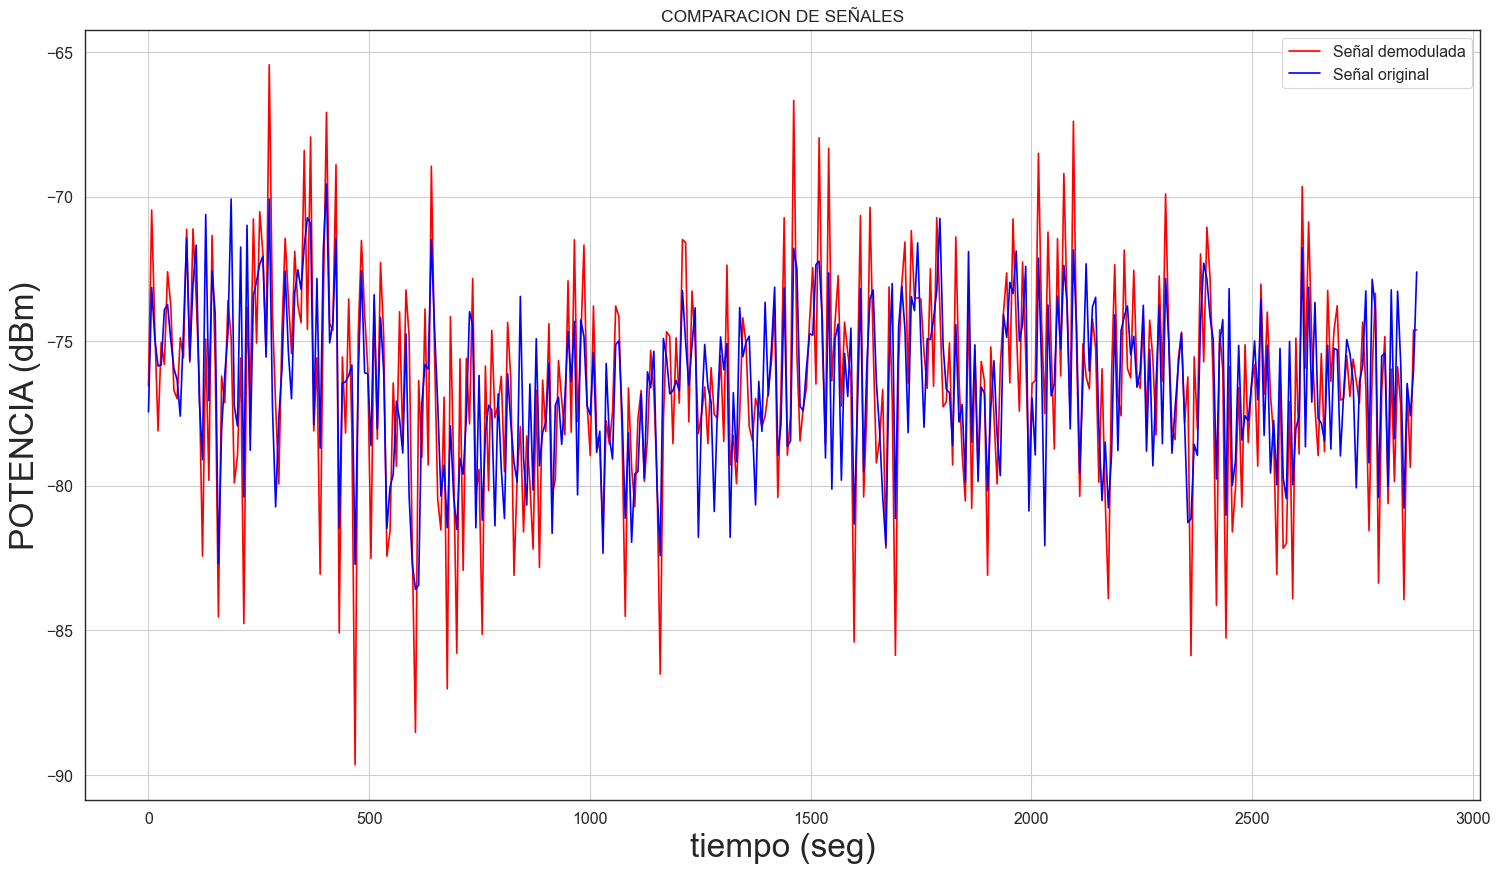

In [56]:

mdt_orig=spectrum[feature:len(Y_new)+feature]
plt.figure(figsize=(18,10))
plt.plot(t[:400], mdt_1[:400],color= 'r')
#plt.stem(t[:200], mdt_1[:200], 'r','o')
#plt.title("SEÑAL DEMODULADA")
plt.grid(True)

plt.plot(t[:400], mdt_orig[:400],color='b')
#plt.stem(t[:200], mdt_orig[:200],'b','o')
plt.title("COMPARACION DE SEÑALES")
plt.ylabel('POTENCIA (dBm)', size=24)
plt.xlabel('tiempo (seg)', size=24)
plt.legend(('Señal demodulada', 'Señal original',), loc='best')
plt.grid(True)
plt.show()

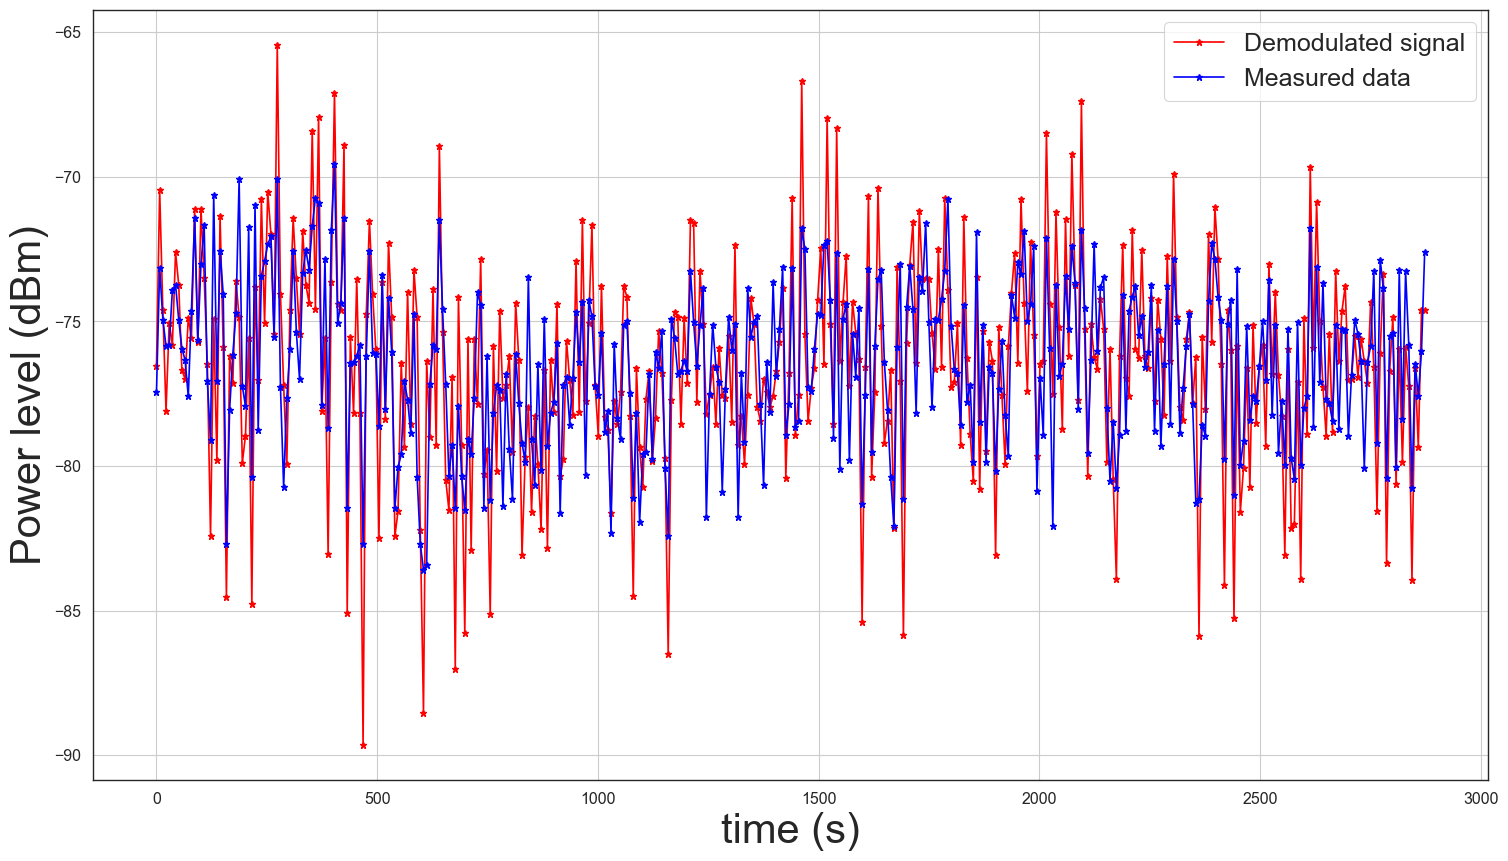

In [57]:
#plt.figure(figsize=(18,10))
#plt.plot(t[:400], mdt_1[:400], color = 'red', marker = "*",)
#plt.grid(True)

#plt.plot(t[:400], mdt_orig[:400], color = 'b', marker = "*",)

#plt.title("COMPARACION DE SEÑALES")
#plt.ylabel('Power level (dBm)', size=30)
#plt.xlabel('time (s)', size=30)
#plt.legend(('Demodulated signal', 'Measured data',),fontsize=18, loc='best')
#plt.grid(True)
#plt.show()

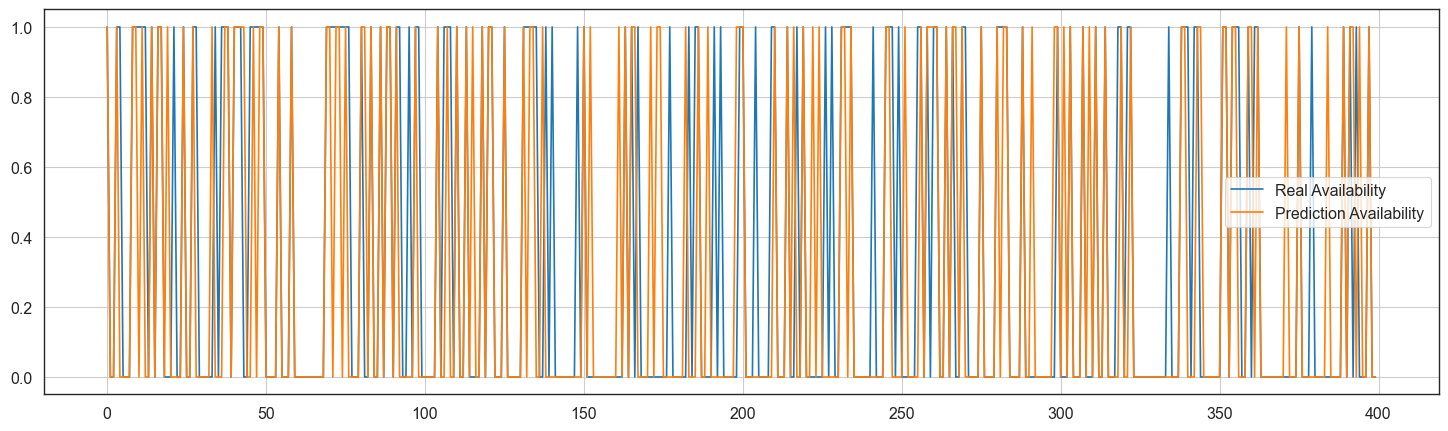

In [58]:
#Gráficando disponibilidad

plt.figure(figsize=(18,5))
#plt.plot(X_orig[:len(X_orig)-9500])
#plt.plot(Y_pr[:len(Y_pr)-9500])
plt.plot(X_orig[200:600])
plt.plot(Y_pr[200:600])
plt.legend(('Real Availability','Prediction Availability'), loc='best')
plt.grid(True)
plt.show()



In [59]:
resultados1=pd.DataFrame(resultados)
resultados1.to_csv ('outputMODUL.csv',index=False)